# NEWSGROUPS Edits Analysis

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from evaluate import load
from matplotlib.ticker import PercentFormatter
from pylev import levenshtein as lev_dist

from utils.gpt2_functions import *

## Main Code

### Helping Functions

In [2]:
def plot_distribution(scores, x_title, nbins=None, xticks_interval=0.2):
    plt.figure(figsize=(12, 6))
    plt.hist(scores, bins=nbins, weights=np.ones(len(scores)) / len(scores))
    plt.xticks(np.arange(0, max(scores), xticks_interval))
    plt.title(x_title + ' Distribution')
    plt.xlabel(x_title)
    plt.ylabel('Edits Percentage')

    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.show()

In [3]:
def get_statistics(scores, score_name):
    print(f'Max {score_name.lower()}: {max(scores)}')
    print(f'Min {score_name.lower()}: {min(scores)}')
    print(f'Mean {score_name.lower()}: {np.mean(scores)}')

### Load Data

In [4]:
counter_sents = pd.read_csv('../Edits/newsgroups/gnn_newsgroups_edge_filter_edits.csv').values.tolist()
original_sents = pd.read_csv('../Data/newsgroups.csv')[['text']].values.tolist()

assert len(counter_sents) == len(original_sents)

### Fluency Analysis

In [ ]:
# first plot fluency for each pair of sentences
cuda = not torch.cuda.is_available()
model, tokenizer = model_init('t5-base', cuda=cuda)
fluency_scores = []
for i in tqdm(range(len(counter_sents))):
    fl_score = sent_scoring(model, tokenizer, counter_sents[i][0], cuda=cuda)[0] / sent_scoring(model, tokenizer,                 original_sents[i][0], cuda=cuda)[0]

    fluency_scores.append(fl_score)

In [6]:
get_statistics(fluency_scores, 'Fluency Score')

Max fluency score: 3.136893390489069
Min fluency score: 0.3311195730287488
Mean fluency score: 1.0162755753461896


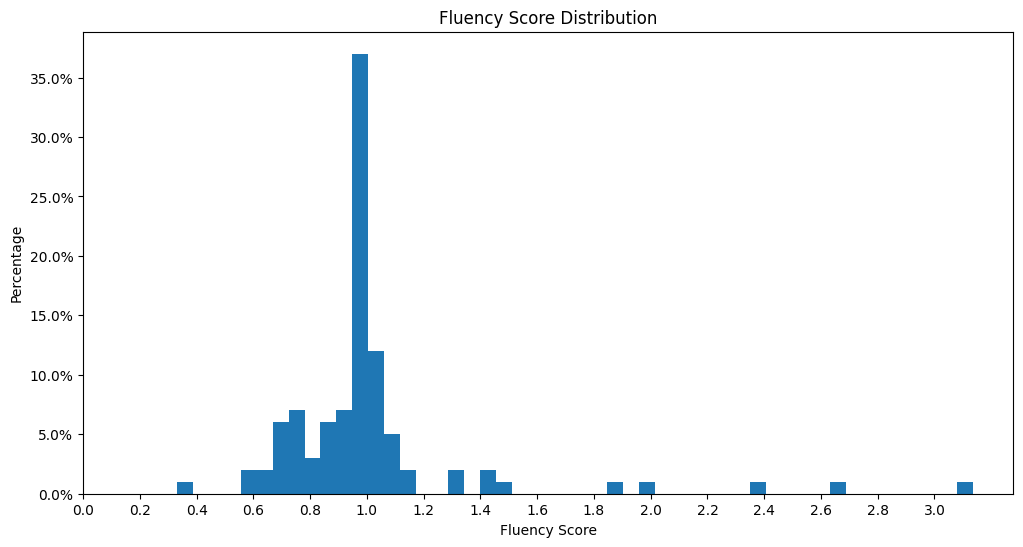

In [7]:
plot_distribution(fluency_scores, 'Fluency Score', nbins=50)

In [8]:
# finding outliers
for i in range(len(fluency_scores)):
    if fluency_scores[i] < 0.7 or fluency_scores[i] > 2:
        print(f'Original: \n{original_sents[i][0]}')
        print(f'Counter: \n{counter_sents[i][0]}')
        print(f'Fluency Score: {fluency_scores[i]}')
        print()

Original: 
I am planning on buying a repair manual for my ford taurus. (92). Is the $53 Ford shop manual comprehensive  enough , covering repairs in all aspects of the car ?    how about the haynes manual for tarus ?  please email replies if possible.
Counter: 
i am planning on font a repair manual for my ford taurus. (92). is the $53 ford shop dogma comprehensive enough , covering repairs in all aspects of the car ? how wonder the haynes manual for tarus ? please email replies if possible.
Fluency Score: 0.6995431281211378

Original: 
I do. Yesterday.  Seriously, Countess Ada of Lovelace gets the credit.  She first used it in the late 80s.  Her bike:  the spokeless wonder.   Jack Waters II DoD#1919
Counter: 
i do. yesterday. seriously, countess ada of lovelace gets the credit. she historical used it in the leave 80s. her bike: the spokeless wonder. jack waters ii dod#1919
Fluency Score: 0.5719398946347415

Original: 
    I assume that can only be guessed at by the assumed energy of th

### Bertscore Analysis

In [9]:
bertscore = load("bertscore")
os = [x[0] for x in original_sents]
cs = [x[0] for x in counter_sents]

bert_scores = bertscore.compute(predictions=cs, references=os, model_type="distilbert-base-uncased")['f1']

In [10]:
get_statistics(bert_scores, 'Bertscore')

Max bertscore: 0.9992573261260986
Min bertscore: 0.9042134881019592
Mean bertscore: 0.9849335151910782


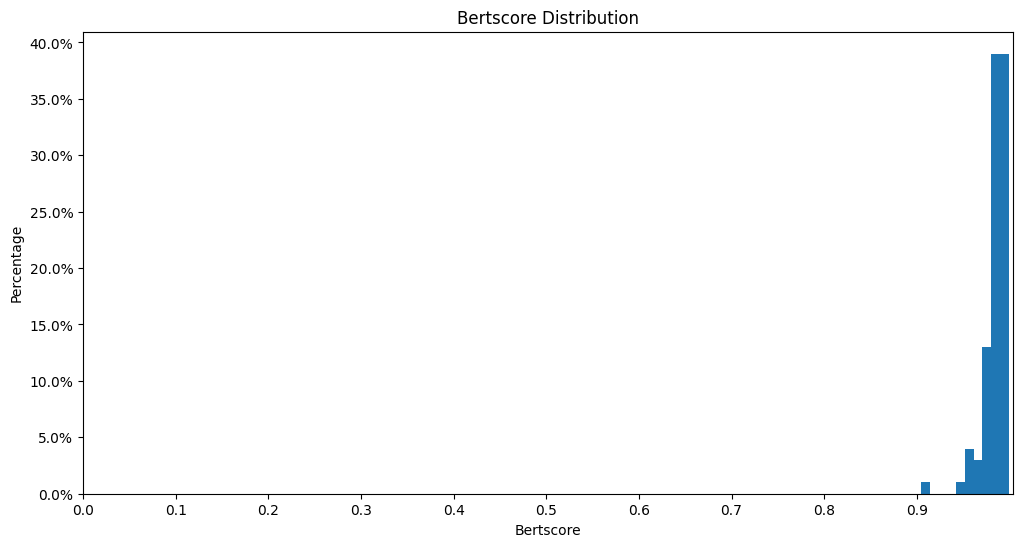

In [11]:
plot_distribution(bert_scores, 'Bertscore', nbins=10, xticks_interval=0.1)

### Closeness (Levenshtein Distance) Analysis

In [12]:
lev_scores = []
for i in tqdm(range(len(counter_sents))):
    num_words = len(original_sents[i][0].split())
    lev_scores.append(lev_dist(original_sents[i][0].lower(), counter_sents[i][0]) / num_words)

100%|██████████| 100/100 [00:32<00:00,  3.06it/s]


In [13]:
get_statistics(lev_scores, 'Levenshtein Distance')

Max levenshtein distance: 4.345454545454546
Min levenshtein distance: 0.0330188679245283
Mean levenshtein distance: 0.5221330619062254


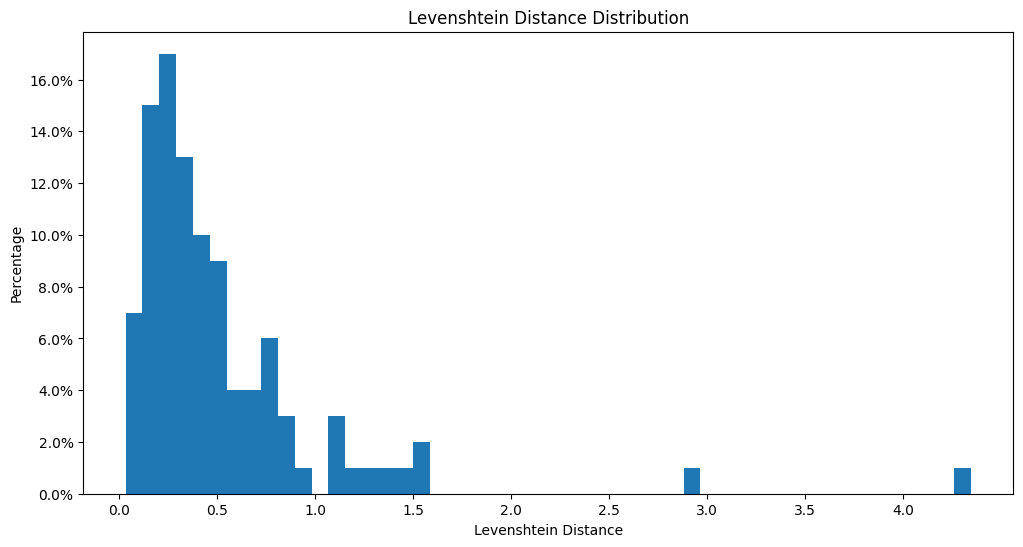

In [16]:
plot_distribution(lev_scores, 'Levenshtein Distance', nbins=50, xticks_interval=0.5)

In [18]:
# finding outliers
for i in range(len(lev_scores)):
    if lev_scores[i] > 1:
        print(f'Original: \n{original_sents[i][0]}')
        print(f'Counter: \n{counter_sents[i][0]}')
        print(f'Levenshtein Distance: {lev_scores[i]}')
        print()

Original: 
I'm looking for a printer driver for the Apple Imagewriter II. (This printer is actually the same as a Citoh 8510.  --
Counter: 
i'm looking for a printer emphasis for the apple imagewriter ii. (this ambient is actually the registration as a citoh 8510. --
Levenshtein Distance: 1.1363636363636365

Original: 
Does anyone know of any free X-servers for PCs, preferably that run under MS Windows? THANKS.
Counter: 
does anyone non of any proposal x-servers for pcs, preferably that buggy under answer windows? thanks.
Levenshtein Distance: 1.125

Original: 
element analysis, radiosity, distributed processing  Hi,   I'm looking for references to parallel algorithms on:    octrees   adaptive subdivision   adaptive meshing   finite element meshing/analysis   radiosity   Any help will be greatly appreciated.  E-mail replies to
Counter: 
anticholinergic analysis, radiosity, distributed processing hi, i'm more for references to parallel algorithms on: octrees adaptive subdivision adapti